# Homogenization of elastic properties of composites
The mechanical behavior of structures composed of phases with different properties can be estimated based on the theoretical models of Voigt and Reuss. In this tutorial, composites with a matrix and a filler phases are investigated with respect to their elastic properties. The results of the numerical simulation with the Finite Elemnt Method (FEM) are compared to the theoretical values. Finite Element Analysis is performed with the pyLabFEA package, see the <a rel="docs" href="https://ahartmaier.github.io/pyLabFEA/">online documentation</a> and the tutorial <a rel="Intro" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-1-introduction">Introduction</a> for detailed information on the functionality of the package. For further studies on the behavior of linear-elastic composites, please open the tutorial <a rel="Comp" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-2-composites">Composites</a>. 

This Jupyter notebook uses ipywidgets for user interactions, the matplotlib (https://matplotlib.org/) library for the visualization of results, and NumPy (http://www.numpy.org) for mathematical operations with arrays.

Author: Alexander Hartmaier, ICAMS / Ruhr-Universität Bochum, Germany

July 2025

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 

### Read libraries and define global objects

**Note: All cells must be run individually in sequence to allow for user-defined inputs.**

In [1]:
%matplotlib widget
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# get absolute path to paket with class and widget definitions
package_path = os.path.abspath('../libs')
if package_path not in sys.path:
    sys.path.insert(0, package_path)

import ml_lib as ml


The scikit-learn intel acceleration is not installed on your system


## 1. Create simulation model and specifiy properties of matrix and filler materials

In the first step, basic elements of the Finite Element Model of a composite material are defined. This requires the definition of the elastic properties of matrix and filler phases, as well as the definition of the finite element mesh and the boundary conditions for the simulation of mechanical behavior of the composite.

In [2]:
"""
Unit system for this Notebook:
Young's modulus: 1 GPa
Strain: 1 %

Unit system for pyLabFEA:
Stress: 1 MPa
Strain: 1 (dimensionless)
Length: 1 mm
"""

ui_mat = ml.mat_gui()
display(ui_mat.table)


In the next step, the finite element model `comp` is created based on the user input and a database object `prop` for the properties resulting from finite element simulations of tensile tests on the composite is initialized.

In [3]:
# define object for composite model based on user-defined parameters
param = ui_mat.read_param()
comp = ml.Composite(param)

#define object for mechanical properties of different composite materials
prop = ml.ResultDB(param['E1'], param['E2'])

## 2. Define geometrical arrangement of filler phase
In this step, a finite element model of a composite with 100% matrix phase is created. The user can specify the geometrical arrangement of the regions to which the filler phase should be assigned by clicking on the finite element in the upper left corner and the finite element in the lower right corner of the rectangle to be changed into filler phase. By pressing the button `Update` the elements containing the filler phase will be displayed in yellow, while the matrix phase is displayed in purple. Note that only the last two points clicked will be used. With the button `Erase` the complete choice can be removed and all finite elements will be assigned again to matrix phase. The button `Finish` will finalize the choice of the geometrical arrangement of the filler phase and deactivate all buttons to avoid further changes.  
During update and finish operations, the volume fraction of filler phase and the shape parameter of the geometrical arrangement will be analysed and printed. The volume fraction is defined as the number of finite elements assigned to filler phase divided by the total number of finite elements. The shape parameter correspnd to the so-called lineal path function analysis of the geometrical arrangement. During this analysis, the $x$ and $y$-sizes of all regions assigned to filler phase will be evaluated and the minimum and maximum size in each direction is used as a shape parameter.

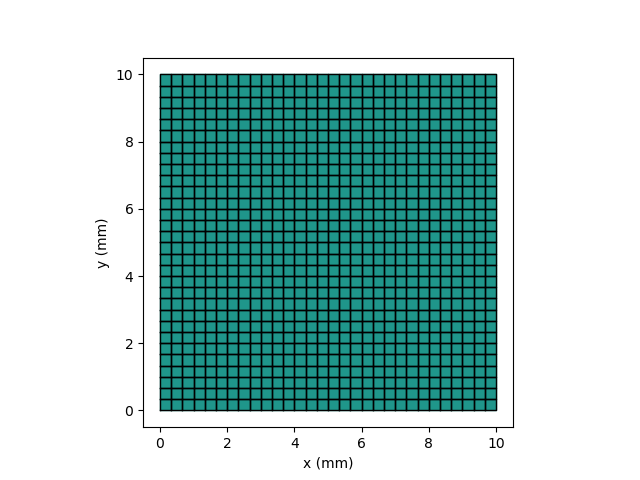

In [22]:
# create and plot initial model
comp.create_model()  # create model with 100% matrix phase
ui_comp, fig, ax, coords, cpairs, cid = ml.model_gui(comp)
display(ui_comp)

## 3. Perform finite element simulation of tensile test
In this step, a tensile test on the composite structure is simulated with the finite element method. As a results, the stresses and strain during the tensile test are returned, which will be used later to plot the stress-strain curves. Furthermore, the different stress components within the microstructure of the composite at maximum load are plotted.  
First, a tensile test in vertical direction is simulated and evaluated.  
**Note:** The use of the "%matplotlib widget" option require that all plots are closed, because otherwise they will remain active in the background and consume too much memory capacity.

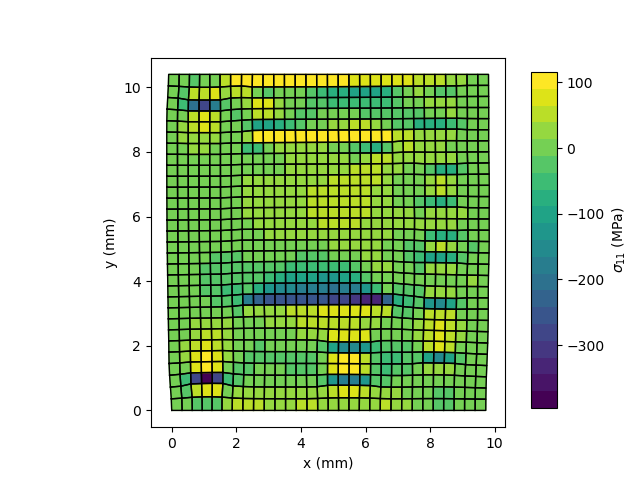

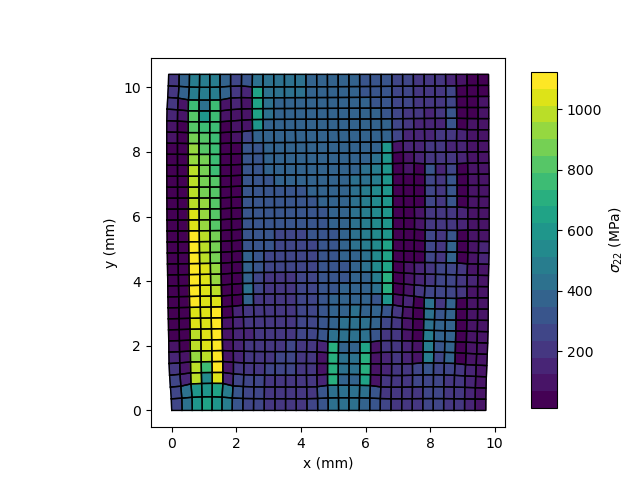

In [23]:
comp.close_plots()

# perform tensile test in vertical direction
sig_vert, eps_vert = comp.tensile('vertical')
fig, ax = comp.plot('stress1')
fig, ax = comp.plot('stress2')

Second, a tensile test in horizontal direction is performed.

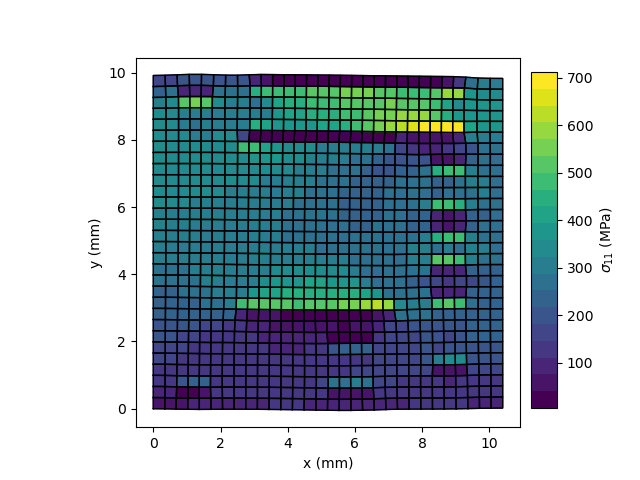

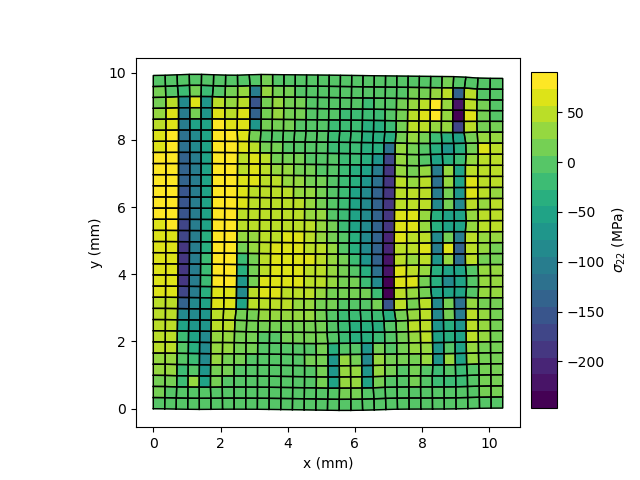

In [24]:
comp.close_plots()

# perform tensile test in horizontal direction
sig_hor, eps_hor = comp.tensile('horizontal')
fig, ax = comp.plot('stress1')
fig, ax = comp.plot('stress2')


Plot stress-strain curves for both loading directions and compare them to the stress-strain curves of matric and filler phases.

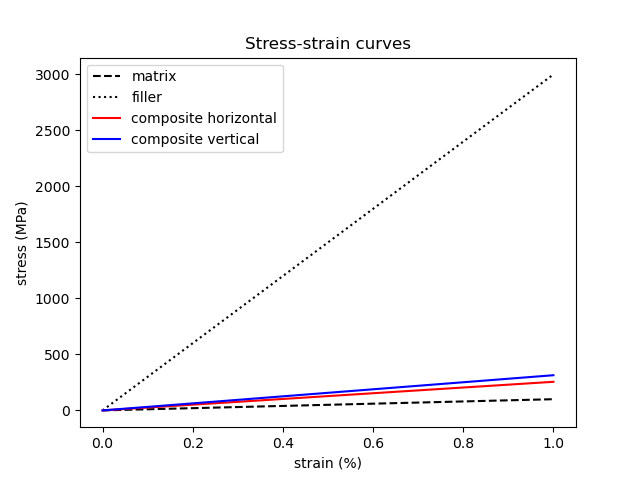

In [25]:
comp.close_plots()

# plot stress-strain curves of matrix, filler and composite in different loading directions
fig = plt.figure()
plt.plot(comp.mat1.sigeps['sty']['eps'][:, 1]*100,
         comp.mat1.sigeps['sty']['sig'][:, 1],
         '--k', label=comp.mat1.name)  # plot equiv. strain (eeq) vs. equiv. stress (seq)
plt.plot(comp.mat2.sigeps['sty']['eps'][:, 1]*100,
         comp.mat2.sigeps['sty']['sig'][:, 1],
         ':k', label=comp.mat2.name)  # for uniaxial tensile stress in vertical direction (sty)
plt.plot(eps_hor[:,0]*100., sig_hor[:,0], '-r', label='composite horizontal')
plt.plot(eps_vert[:,1]*100., sig_vert[:,1], '-b', label='composite vertical')
plt.title('Stress-strain curves')
plt.xlabel(r'strain (%)')
plt.ylabel(r'stress (MPa)')
plt.legend()
plt.show()


## 4. Add values of this composite to database
In the final step, the effective Young's modulus of the composite with the current geometrical arrangement of the filler phase is calculated from the stress-strain data. In this way, the elastic properties for loading in vertical and horizontal direction are obtained and stored in the results database, together with the geometry information on volume fraction and shape parameters.  
This data will be used later for the training of a machine learning model that predicts the elastic properties of a composte material with an arbitrary arrangement of the filler phase.

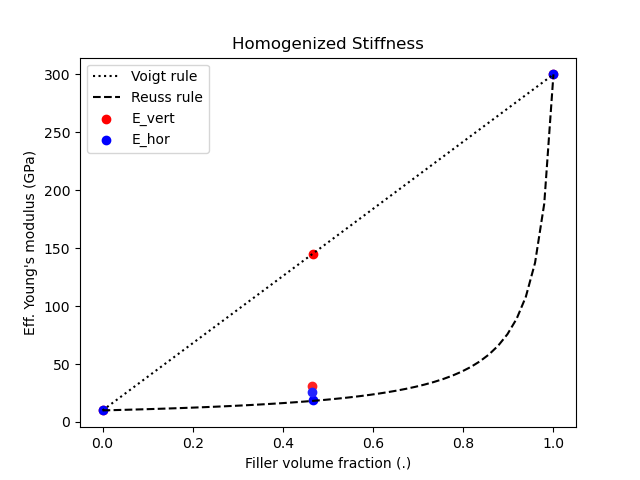

In [26]:
plt.close(fig)

# calculate Young's moduli in different directions
E_vert = (sig_vert[-1, 1] - sig_vert[0, 1]) * 1.0e-3 /  (eps_vert[-1, 1] - eps_vert[0, 1])  # Young's modulus in GPa
E_hor = (sig_hor[-1, 0] - sig_hor[0, 0]) * 1.0e-3 /  (eps_hor[-1, 0] - eps_hor[0,0 ])

# evaluate volume fraction and shape parameters
vf, shape = comp.calc_geom_param()
cpairs = np.array(cpairs) / param['nel']

prop.add(vf, shape, cpairs, E_vert, E_hor, param['E1'], param['E2'])
#prop.read('results_10_300.json')
fig = prop.plot()

In [27]:
plt.close(fig)

# save results database for future use
prop.write(fname='../data/results_10_300.json')

## 5. Repeat calculations for different filler geometries
Please repeat the different steps, starting from Section 2 to Section 4 of this notebook. Test many different volume fractions and geometrical arrangements of the filler phase to obtain a good understanding of the elastic properties of composites. Furthermore, the data you generate here will be used later for training a machine learning model predicting the elastic properties of a composite.